In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats

# Load posterior parameter distributions (from ABC) -- F04

Fit gamma distribution to the posteriors

In [21]:
Input_H = [1500,0,0,0]
parameters = [Input_H]

θ = np.load('ABC/ABC_season/theta_Season_F04_3.npy')

In [3]:
a_β, loc_β, scale_β = stats.gamma.fit(θ[4][:,0])
a_ϵ, loc_ϵ, scale_ϵ = stats.gamma.fit(θ[4][:,1])
a_σ, loc_σ, scale_σ = stats.gamma.fit([1/a for a in θ[4][:,2]])
a_μ1, loc_μ1, scale_μ1 = stats.gamma.fit([1/a for a in θ[4][:,3]])
a_μ2, loc_μ2, scale_μ2 = stats.gamma.fit([1/a for a in θ[4][:,4]])

# Use SEIR model -- split up rate from human to human and external

In [4]:
def gillespieSEIR_season(initial, beta, mu1,mu2, sigma,epsilon):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    num_external= 0
    num_internal = 0
    Rtotal = 1
    death = 0
    while Rtotal>0:
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
        if np.round(times)%365 <= 120:
            E = epsilon
        else:
            E = 0
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        R_external = E*pop[ind][0]
        state[:,0] = [-1,1,0,0]
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N  
        state[:,1] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,2] = [0, -1, 1, 0]
        
        R_ir = mu2*pop[ind][2]
        state[:,3] = [0,0,-1,1]

        R_is = mu1*pop[ind][2]
        state[:,4] = [1,0,-1,0]
        

########################## RATES ##############################
        rate = [R_external, R_se, R_ei,  R_ir,  R_is]
        Rtotal = sum(rate)

        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
            if event == 0:
                num_external +=1
            if event == 1:
                num_internal +=1
            if event == 3:
                death +=1 
            if event == 2:
                cuminf.append(1 +cuminf[ind] )
            else:
                cuminf.append(0 +cuminf[ind])
            ind=ind+1
        N = sum(pop[ind][:2])
    return event_time, np.array(pop), events, cuminf, num_external, num_internal, death

# Run multiple stochastic simulations (1000)

In [5]:
external = []
internal = []
total = []
death = []
for k in range(1000):
    beta = stats.gamma.rvs( a_β, loc_β, scale_β)
    mu1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
    mu2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
    epsilon = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)
    sigma = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
    M=gillespieSEIR_season(parameters[0], beta, mu1,mu2,
                          sigma,epsilon)
    external.append(M[4])
    internal.append(M[5])
    total.append(M[3][-1])
    death.append(M[6])

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in double_scalars
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


In [7]:
print('percent of fatal infections ', 100*np.mean([death[a]/total[a] for a in range(len(death))]),'%')

percent of fatal infections  49.71204509644757 %


In [8]:
print('percent of infections from external forcing', 100*np.mean([external[a]/total[a] for a in range(len(external))]),'%')
print('percent of infections from human to human transmission', 100*np.mean([internal[a]/total[a] for a in range(len(internal))]),'%')

percent of infections from external forcing 57.32441343018022 %
percent of infections from human to human transmission 42.67558656981977 %


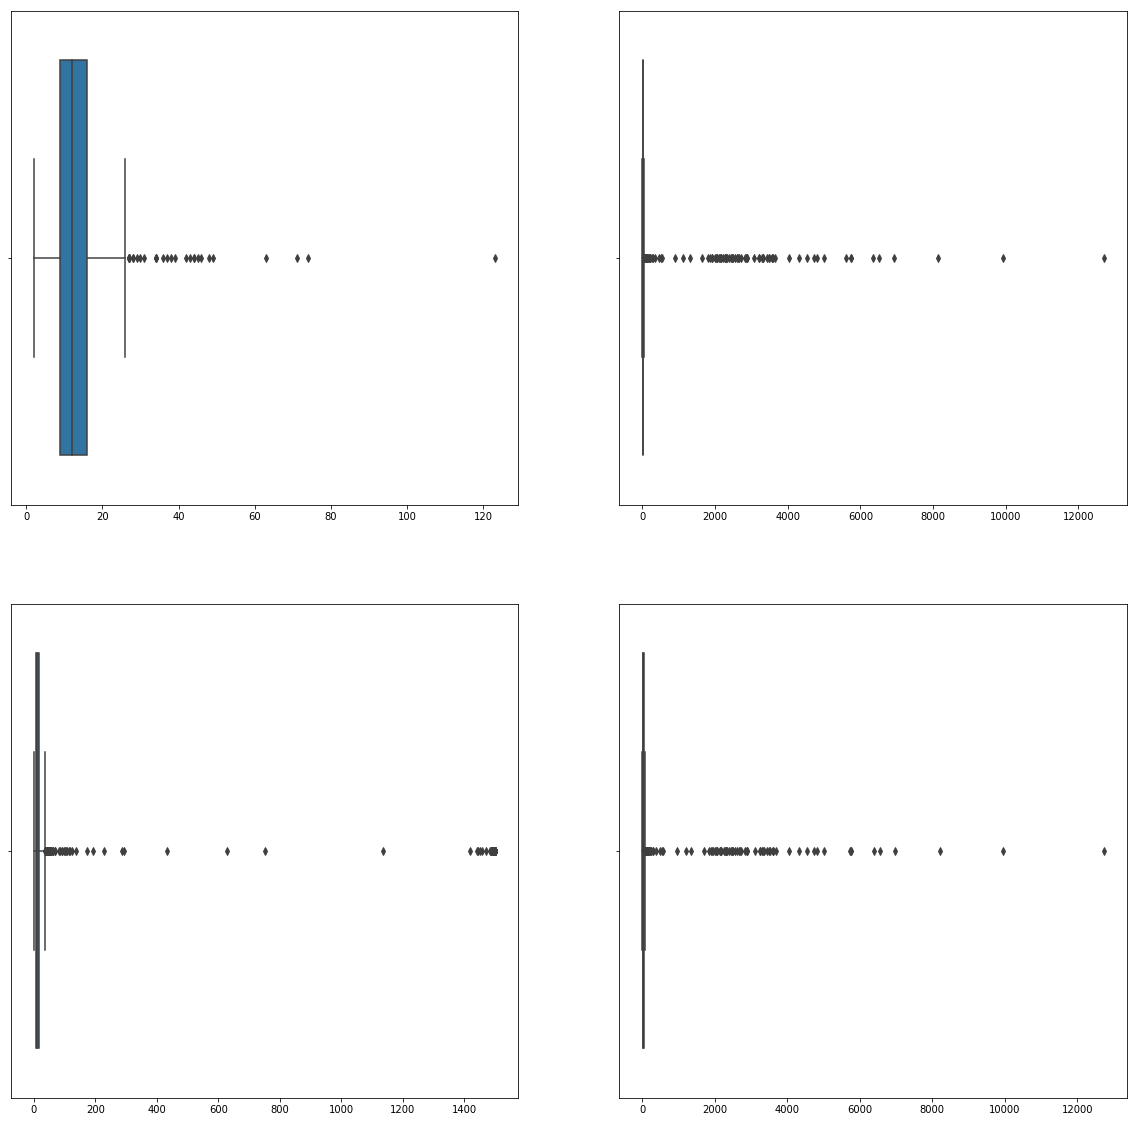

In [9]:
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
sns.boxplot(external)

plt.subplot(2,2,2)
sns.boxplot(internal)

plt.subplot(2,2,3)
sns.boxplot(death)
plt.subplot(2,2,4)
sns.boxplot(total)

# Reproductive Number -- without external infection
Life expectancy 72 years (2015) in Bangladesh but 67 (2004)

$$ R_0 = \frac{\beta \sigma}{(\sigma +\mu)(\mu1+\mu2+\mu)} $$

In [18]:
β = stats.gamma.rvs( a_β, loc_β, scale_β)
μ1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
μ2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
σ = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
μ = 1/(365*67)
ϵ = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)

R_0_H = (β*σ)/((σ+μ)*(μ1+μ2+μ)) 
R_0_H

0.5869618146562724

# Reproductive Number -- with external infection 

Fit Expoential to growth rate -- rate per day per population level

In [20]:
Gh=gillespieSEIR_season(parameters[0], β, μ1,μ2,
                          σ,ϵ)
SEIHRt_s = Gh[0]
SEIHRs_s = Gh[1][:,0]
SEIHRe_s = Gh[1][:,1]
SEIHRi_s = Gh[1][:,2]
SEIHRr_s = Gh[1][:,3]

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in double_scalars


In [23]:
manhes = []
manhts = []
manhhs = []
manhis = []
manhss = []
manhrs = []
cum = []
for ind, x in enumerate(SEIHRt_s):
    if ind<len(SEIHRt_s)-1:
        manhes.append((SEIHRe_s[ind], SEIHRe_s[ind]))
        cum.append((Gh[3][ind], Gh[3][ind]))
        manhis.append((SEIHRi_s[ind], SEIHRi_s[ind]))
        manhss.append((SEIHRs_s[ind], SEIHRs_s[ind]))
        manhrs.append((SEIHRr_s[ind], SEIHRr_s[ind]))
        manhts.append((SEIHRt_s[ind], SEIHRt_s[ind+1]))
manhes = np.array(manhes).flatten()
manhts = np.array(manhts).flatten()
manhss = np.array(manhss).flatten()
manhrs = np.array(manhrs).flatten()
cum = np.array(cum).flatten()
manhis = np.array(manhis).flatten()

(0, 300)

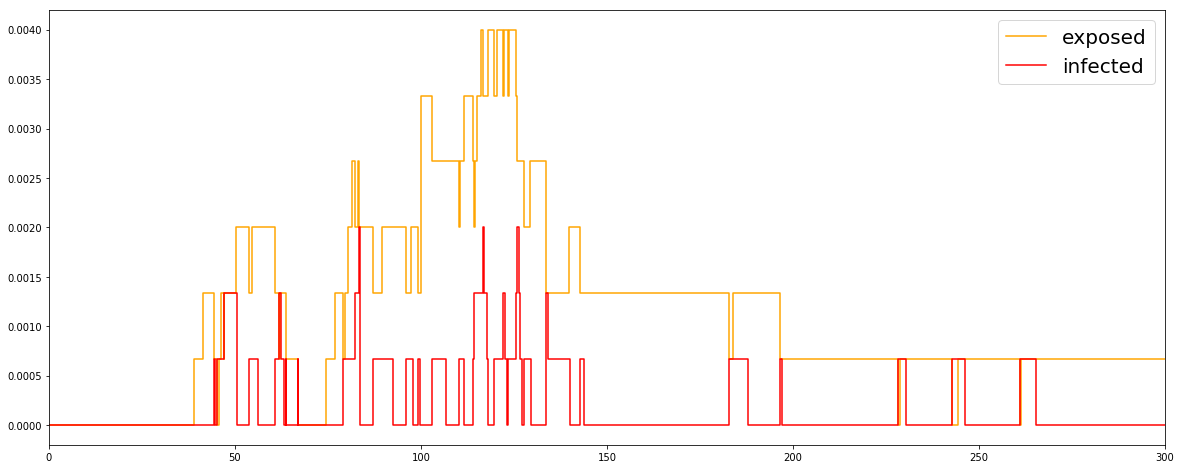

In [34]:
plt.figure(figsize = (20,8))
N = sum(Input_H)
plt.plot(manhts, manhes/N,c='orange', label = 'exposed')

plt.plot(manhts,manhis/N,c= 'r', label = 'infected')
plt.legend(fontsize = 20)
plt.xlim([0,300])

(0, 50)

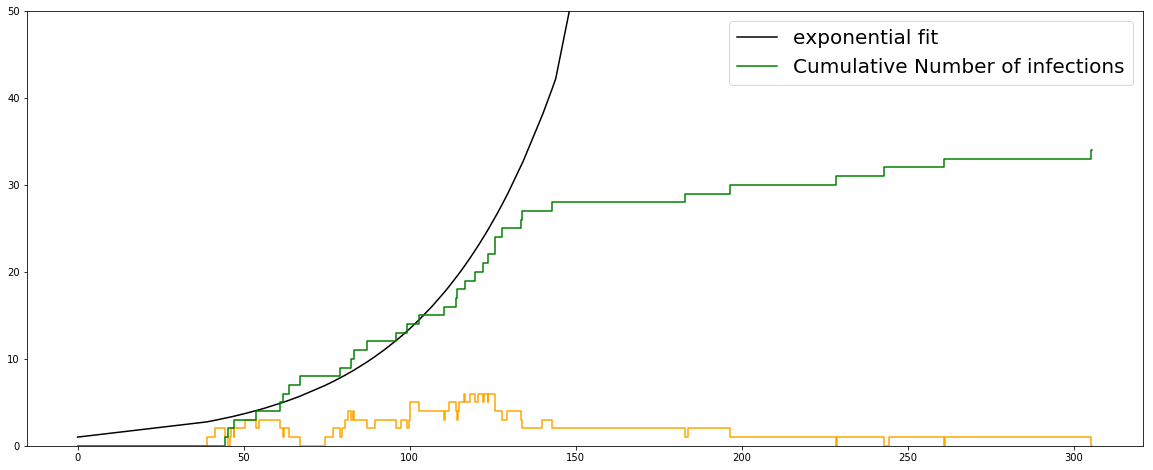

In [50]:
plt.figure(figsize = (20,8))
plt.plot(manhts, manhes, color = 'orange')
plt.plot(manhts, np.exp(0.026*manhts), color = 'black', label ='exponential fit')
plt.plot(manhts, cum, color = 'green', label = 'Cumulative Number of infections')
plt.legend(fontsize = 20)
plt.ylim([0, 50])


# Distribution of number of exposed before observing the initial infections

In [51]:
def SEIRexposed(initial, beta, mu1,mu2, sigma,epsilon):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    num_external= 0
    num_internal = 0
    exposed = 0
    Rtotal = 1
    death = 0
    while pop[ind][2]<1:
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
        if np.round(times)%365 <= 120:
            E = epsilon
        else:
            E = 0
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        R_external = E*pop[ind][0]
        state[:,0] = [-1,1,0,0]
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N  
        state[:,1] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,2] = [0, -1, 1, 0]
        

        
        R_ir = mu2*pop[ind][2]
        state[:,3] = [0,0,-1,1]
        

        R_is = mu1*pop[ind][2]
        state[:,4] = [1,0,-1,0]
        

########################## RATES ##############################
        rate = [R_external, R_se, R_ei,  R_ir,  R_is]

        Rtotal = sum(rate)

        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
            if event == 0:
                num_external +=1
                exposed +=1 
            if event == 1:
                num_internal +=1
                exposed +=1
            if event == 3:
                death +=1 
            if event == 2:
                cuminf.append(1 +cuminf[ind] )
            else:
                cuminf.append(0 +cuminf[ind])
            ind=ind+1
        N = sum(pop[ind][:2])
    return event_time, np.array(pop), events, cuminf, num_external, num_internal, death, exposed

In [52]:
external = []
internal = []
total = []
death = []
exposed = []
for k in range(1000):
    beta = stats.gamma.rvs( a_β, loc_β, scale_β)
    mu1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
    mu2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
    epsilon = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)
    sigma = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
    M=SEIRexposed(parameters[0], beta, mu1,mu2,
                          sigma,epsilon)
    external.append(M[4])
    internal.append(M[5])
    total.append(M[3][-1])
    death.append(M[6])
    exposed.append(M[7])

1

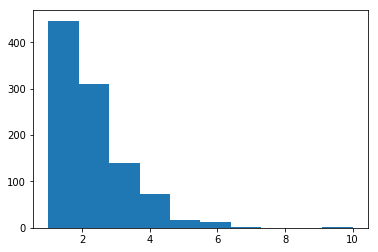

In [53]:
plt.hist(exposed, bins = np.max(exposed))
stats.mode(exposed)[0][0]

In [99]:

# Data_F04=pd.read_csv("Case_data/2004_F_cases.csv",sep = ',', header = 0)
# ############################# Spacing ##############################################
# date_format = "%d/%m/%y"


# def Spacing(dataset):
#     record = []
#     record.append(datetime.strptime(dataset['Date'][0], date_format).day)
#     for i in range(1, len(dataset)):
#         record.append(record[i-1]+(datetime.strptime(dataset['Date'][i], date_format)-datetime.strptime(dataset['Date'][i-1], date_format)).days)
#     start_day = (datetime.strptime(Data_F04['Date'].values[0], date_format)-datetime.strptime('01/11/03', date_format)).days
#     record = [int(a - record[0]) for a in record]
#     record = [int(a +start_day) for a in record]

#     return record

# Rec_F04=Spacing(Data_F04)
# Cum_F04 = Data_F04['CumsumInf'].values
# leng = len(np.arange(0, Rec_F04[0], 2))
# Rec_F04 = np.insert(Rec_F04, 0, np.arange(0, Rec_F04[0], 2))
# Cum_F04 = np.insert(Cum_F04, 0, np.zeros(leng))
# summary = np.array([Rec_F04, Cum_F04])
# plt.plot(M[0], M[3])
# plt.plot(summary[0][:20], summary[1][:20])